<a href="https://colab.research.google.com/github/TAlkam/Infant-Sleeping-Position-Monitoring-with-LSTM/blob/main/Infant_Sleeping_Position_Monitoring_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import Necessary Libraries and Upload dataset**

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

**Upload dataset**

In [5]:
from google.colab import files
uploaded = files.upload()


Saving GD for  IoT device infant safe prediction.csv to GD for  IoT device infant safe prediction.csv


**Step 2: Load dataset, EDA, and Prepare the Dataset**

In [6]:
data = pd.read_csv('GD for  IoT device infant safe prediction.csv')
df = pd.read_csv('GD for  IoT device infant safe prediction.csv')

In [7]:
print(df.columns)

Index(['minutes from the start of recording', 'DeviceDatetTime',
       'leg raised time (seconds)',
       'leg movement (no Movement=0, yes movement=1)',
       'tag1_visibility (visible=1, unvisible=0)',
       'tag2_visibility (visible=5, unvisible=1)',
       'Leg + tag1+tag2 (unsafe=5,  safe=1, safe=2, safe=3, safe=6)',
       'Safety (safe =1, unsafe=5)', 'safety'],
      dtype='object')


**Exploratory Data Analysis (EDA)**

***Overview of the Dataset***

In [9]:
# Display the first few rows of the dataframe
print(df.head())

# Summary statistics for numerical features
print(df.describe())

# Check for missing values
print(df.isnull().sum())


   minutes from the start of recording  DeviceDatetTime  \
0                                    1  11/10/2022 4:37   
1                                    2  11/10/2022 4:38   
2                                    3  11/10/2022 4:39   
3                                    4  11/10/2022 4:40   
4                                    5  11/10/2022 4:41   

   leg raised time (seconds)  leg movement (no Movement=0, yes movement=1)  \
0                      1.010                                             1   
1                      1.033                                             1   
2                      1.023                                             1   
3                      1.093                                             1   
4                      1.020                                             1   

   tag1_visibility (visible=1, unvisible=0)  \
0                                         1   
1                                         1   
2                                  

**Distribution of Numerical Features**

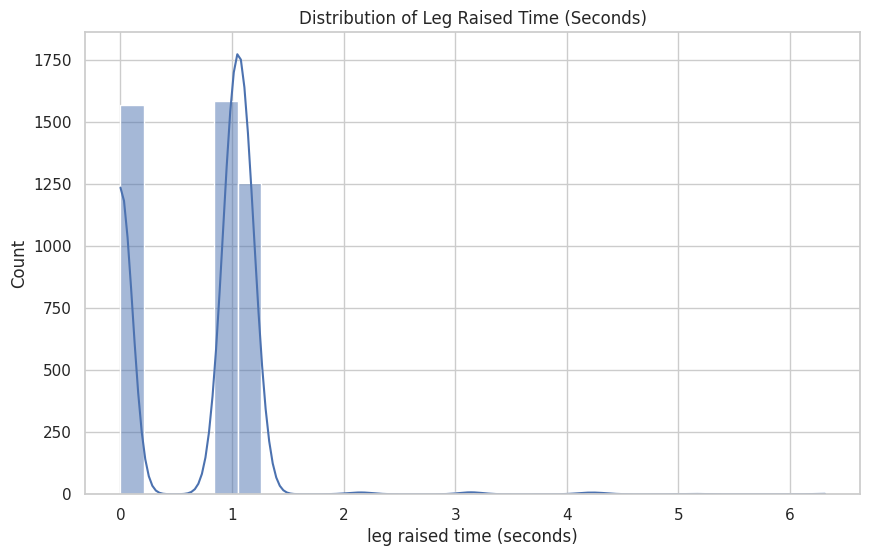

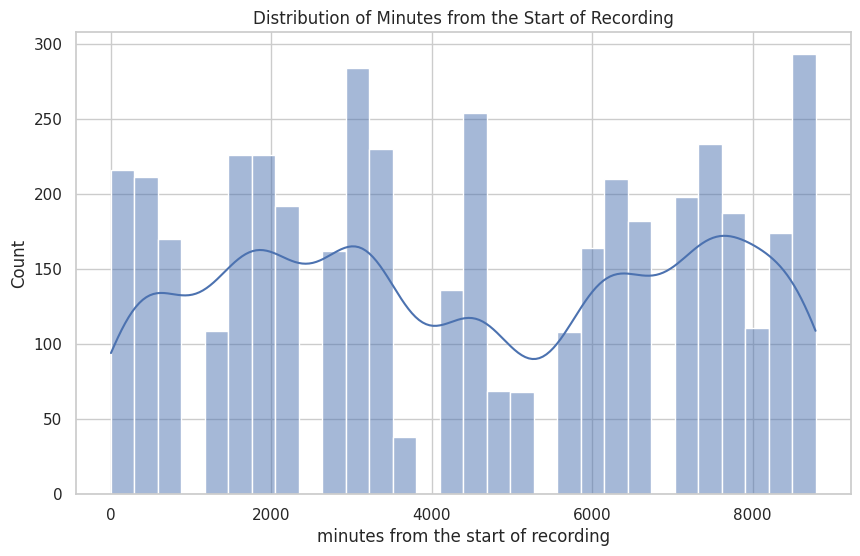

In [10]:
# Distribution of 'leg raised time (seconds)'
plt.figure(figsize=(10, 6))
sns.histplot(df['leg raised time (seconds)'], kde=True, bins=30)
plt.title('Distribution of Leg Raised Time (Seconds)')
plt.show()

# Distribution of 'minutes from the start of recording'
plt.figure(figsize=(10, 6))
sns.histplot(df['minutes from the start of recording'], kde=True, bins=30)
plt.title('Distribution of Minutes from the Start of Recording')
plt.show()


**Analysis of Categorical Features**

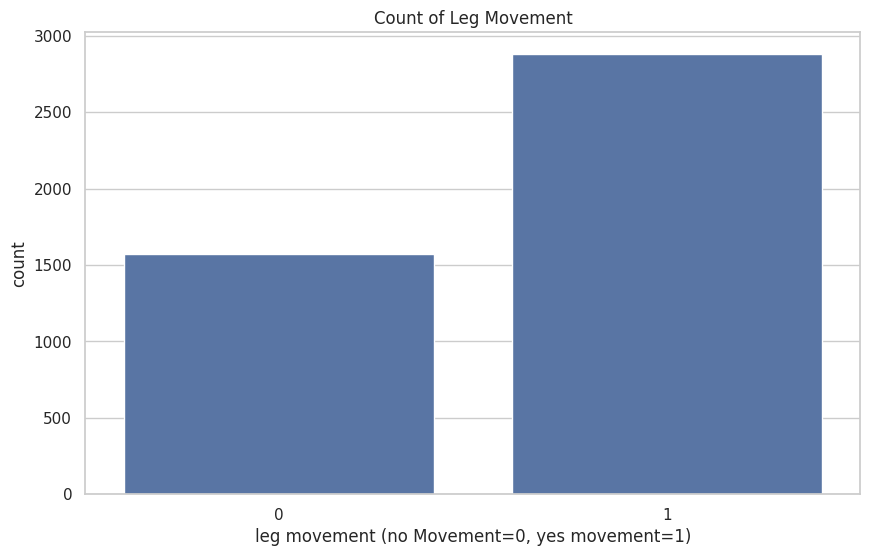

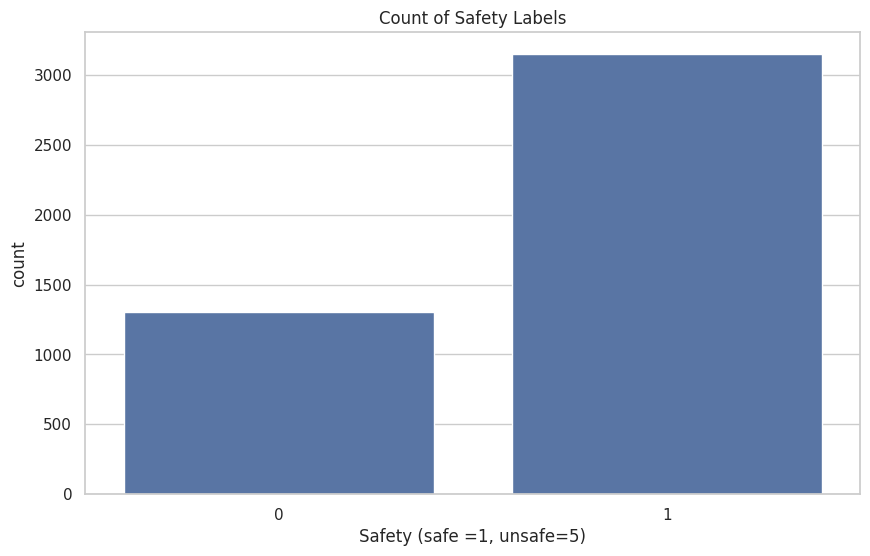

In [11]:
# Count plot for 'leg movement (no Movement=0, yes movement=1)'
plt.figure(figsize=(10, 6))
sns.countplot(x='leg movement (no Movement=0, yes movement=1)', data=df)
plt.title('Count of Leg Movement')
plt.show()

# Count plot for 'Safety (safe =1, unsafe=5)'
plt.figure(figsize=(10, 6))
sns.countplot(x='Safety (safe =1, unsafe=5)', data=df)
plt.title('Count of Safety Labels')
plt.show()


**Correlation Analysis**

<ipython-input-12-3d8ef2ea2e67>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


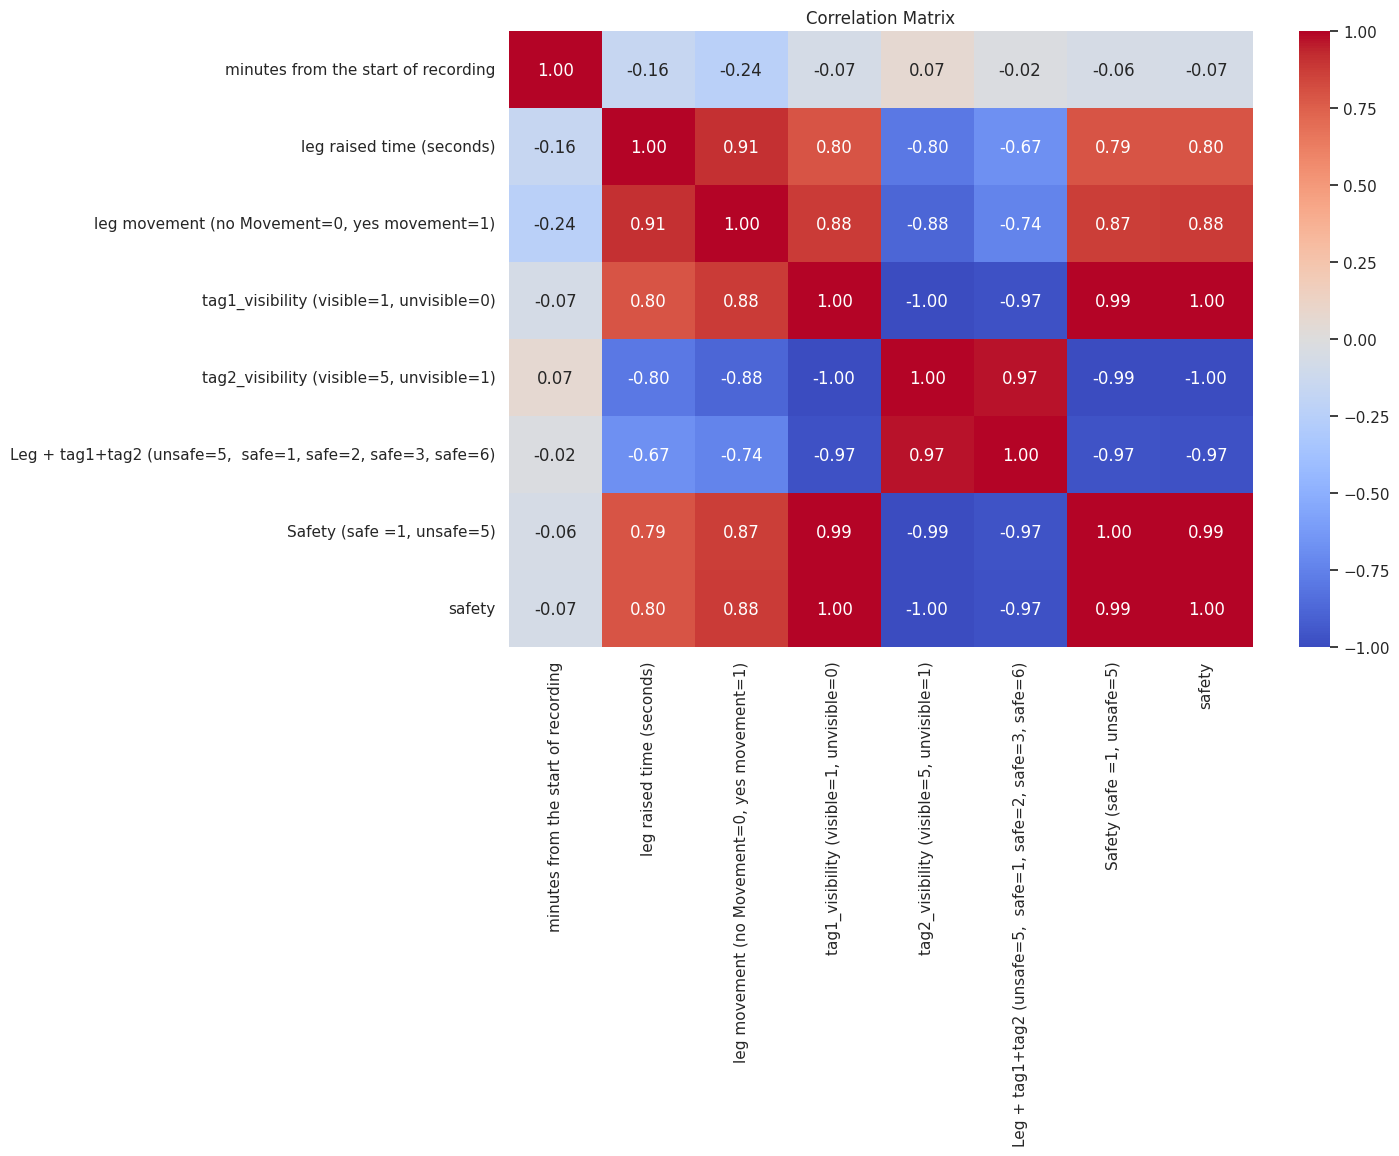

In [12]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


**Time Series Analysis**

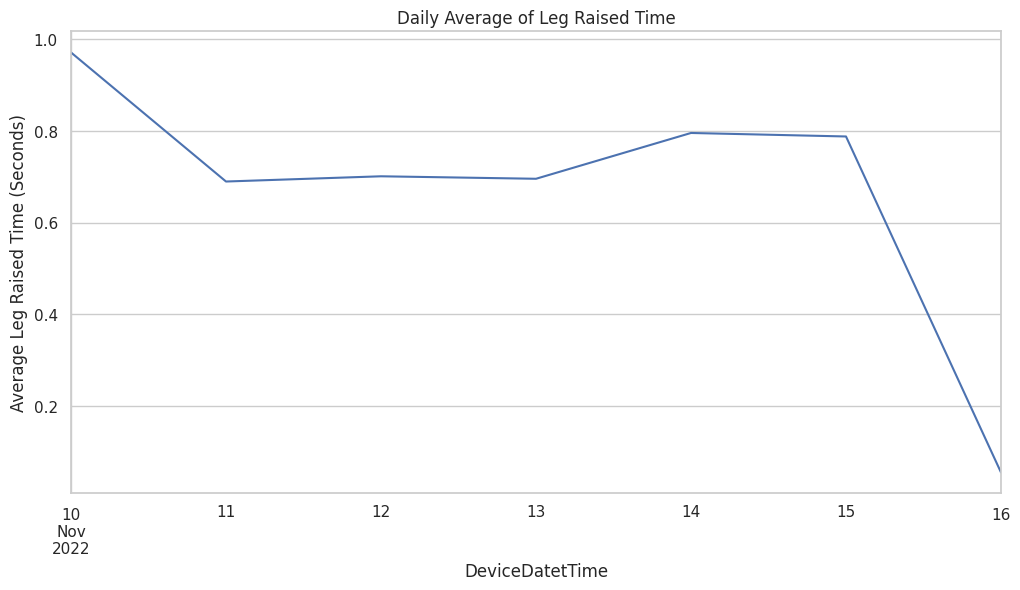

In [13]:
# Ensure 'DeviceDateTime' is in datetime format
df['DeviceDatetTime'] = pd.to_datetime(df['DeviceDatetTime'])

# Resampling or grouping by time period (e.g., daily) and plotting
df.set_index('DeviceDatetTime', inplace=True)
df.resample('D')['leg raised time (seconds)'].mean().plot(figsize=(12, 6))
plt.title('Daily Average of Leg Raised Time')
plt.ylabel('Average Leg Raised Time (Seconds)')
plt.show()


**Correcting the column name based on DataFrame**

In [9]:
# Correcting the column name based on our DataFrame
df['DeviceDatetTime'] = pd.to_datetime(df['DeviceDatetTime'])

# Extract features
df['Hour'] = df['DeviceDatetTime'].dt.hour
df['DayOfWeek'] = df['DeviceDatetTime'].dt.dayofweek
df['Month'] = df['DeviceDatetTime'].dt.month

# Now, drop the original 'DeviceDatetTime' column as its information has been encoded into new features
df = df.drop('DeviceDatetTime', axis=1)


In [7]:
# Correcting the column name for dropping and setting the target variable
X = df.drop(['Safety (safe =1, unsafe=5)', 'safety'], axis=1)  # Drop the target & redundant columns
y = df['Safety (safe =1, unsafe=5)']  # Target variable, using the correct column name


**Step 3: Data Preprocessing**

In [8]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shape of the splits to confirm the sizes
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Testing set size: {X_test.shape}, {y_test.shape}")


Training set size: (3560, 7), (3560,)
Testing set size: (891, 7), (891,)


In [10]:
# Checking the data types of all columns to identify non-numeric columns
print(X_train.dtypes)

minutes from the start of recording                              int64
DeviceDatetTime                                                 object
leg raised time (seconds)                                      float64
leg movement (no Movement=0, yes movement=1)                     int64
tag1_visibility (visible=1, unvisible=0)                         int64
tag2_visibility (visible=5, unvisible=1)                         int64
Leg + tag1+tag2 (unsafe=5,  safe=1, safe=2, safe=3, safe=6)      int64
dtype: object


In [11]:
X_train = X_train.drop('DeviceDatetTime', axis=1)
X_test = X_test.drop('DeviceDatetTime', axis=1)

In [12]:
def define_safety(row):
    if row['tag1_visibility (visible=1, unvisible=0)'] == 1 and row['tag2_visibility (visible=5, unvisible=1)'] == 1 and row['leg movement (no Movement=0, yes movement=1)'] == 1:
        return 1  # Safe
    elif row['tag1_visibility (visible=1, unvisible=0)'] == 0 and row['tag2_visibility (visible=5, unvisible=1)'] == 5 and row['leg movement (no Movement=0, yes movement=1)'] == 0:
        return 0  # Unsafe
    else:
        return np.nan  # for other conditions, you might choose to treat them as safe, unsafe, or exclude them

# Apply the function to create a new 'safety' column
data['safety'] = data.apply(define_safety, axis=1)

# Optional: Remove rows where safety is undefined (np.nan), or handle them as you see fit
data.dropna(subset=['safety'], inplace=True)


In [13]:
# Selecting features and the target
features = data[['leg raised time (seconds)', 'leg movement (no Movement=0, yes movement=1)', 'tag1_visibility (visible=1, unvisible=0)', 'tag2_visibility (visible=5, unvisible=1)']].values
target = data['safety'].values

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Reshape input data for LSTM, if using an LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


**Step 4: Model Definition**

In [14]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


**Step 5: Model Training**

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)


Epoch 1/20
42/42 - 4s - loss: 0.5625 - accuracy: 0.9996 - val_loss: 0.4535 - val_accuracy: 1.0000 - 4s/epoch - 96ms/step
Epoch 2/20
42/42 - 0s - loss: 0.3621 - accuracy: 1.0000 - val_loss: 0.2731 - val_accuracy: 1.0000 - 233ms/epoch - 6ms/step
Epoch 3/20
42/42 - 0s - loss: 0.2104 - accuracy: 1.0000 - val_loss: 0.1533 - val_accuracy: 1.0000 - 258ms/epoch - 6ms/step
Epoch 4/20
42/42 - 0s - loss: 0.1182 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 1.0000 - 237ms/epoch - 6ms/step
Epoch 5/20
42/42 - 0s - loss: 0.0697 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 1.0000 - 226ms/epoch - 5ms/step
Epoch 6/20
42/42 - 0s - loss: 0.0446 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 1.0000 - 233ms/epoch - 6ms/step
Epoch 7/20
42/42 - 0s - loss: 0.0306 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 1.0000 - 258ms/epoch - 6ms/step
Epoch 8/20
42/42 - 0s - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000 - 229ms/epoch - 5ms/step
Epoch 9/20
42/42 -

**Step 6: Model Evaluation**

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")


27/27 - 0s - loss: 0.0027 - accuracy: 1.0000 - 91ms/epoch - 3ms/step
Test Accuracy: 1.0000


**Step 7: Make Predictions**

In [19]:
predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)


27/27 [==============================] - 1s 3ms/step


**Step 8: Evaluate Predictions**

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [22]:
# Assuming `predictions` are your model's predictions, and `y_test` are the actual labels.
# Convert predictions to binary (0 or 1) if they're in a probabilistic form (e.g., output of a sigmoid function).
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


**Step 9: Save and Export Predictions**

In [25]:
# Ensure both arrays are 1-dimensional
y_test_1d = y_test.flatten()  # This is typically already 1D, but using flatten() as a precaution
predictions_binary_1d = predictions_binary.flatten()  # Flatten the predictions to 1D

# Now create the DataFrame
results_df = pd.DataFrame({'Actual': y_test_1d, 'Predicted': predictions_binary_1d})

# Save to CSV
results_df.to_csv('Infant Sleeping Position Monitoring with LSTM_predictions.csv', index=False)

from google.colab import files
files.download('Infant Sleeping Position Monitoring with LSTM_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Step 10: K-Fold Cross-Validation**

In [17]:
# K-Fold Cross-Validation
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Reshape features for LSTM
features_reshaped = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Define K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare to collect scores
scores = []

for train_index, test_index in kf.split(features_reshaped):
    # Split data into training and testing sets
    X_train, X_test = features_reshaped[train_index], features_reshaped[test_index]
    y_train, y_test = target[train_index], target[test_index]

    # Define the LSTM model within the loop to reset it each iteration
    model = Sequential([
        LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)  # Set verbose to 0 to reduce log messages

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    scores.append(accuracy)

# Calculate the average score across all folds
average_score = np.mean(scores)
print(f"Average Accuracy: {average_score:.4f}")


Average Accuracy: 1.0000
